In [1]:
from collections import Counter
import itertools
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.feature_selection import SelectKBest, RFE, chi2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sb

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bad_cntr = pd.read_csv('../data/2-yarobl_bad_contracts.csv')
good_cntr = pd.read_csv('../data/2-yarobl_good_contracts.csv')
data = bad_cntr.append(good_cntr)
data = data.dropna()
data.head(5)

,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,supType,orgForm,price_higher_pmp,price_too_low,price,pmp,okpd,cntr_result
0,1385832,1017,0.00000,0.0,3,466666.0,0.0,1.0,1.0,0,0.0,0.33333,2,8,0,0,700000.0,0.0,0,0
1,1386276,172,0.00000,0.0,1,131000.0,0.0,1.0,1.0,0,0.0,1.00000,3,13,0,0,131000.0,0.0,0,0
2,1387491,82,0.00000,0.0,1,16875000.0,0.0,1.0,1.0,0,0.0,1.00000,3,19,0,0,16875000.0,0.0,0,0
3,1387780,194,0.00515,0.0,1,340000.0,0.0,1.0,1.0,0,0.0,1.00000,3,13,0,0,340000.0,0.0,0,0
4,1387804,194,0.00515,0.0,1,1386000.0,0.0,1.0,1.0,0,0.0,1.00000,3,13,0,0,1386000.0,0.0,0,0


### Группировка OKPD и orgForm

Переменная `okpd` и `orgForm` на выборке принимают более 600 и более 50 значений соответственно. При этом распределение этих
значений крайне неравномерное. 

Так, для переменной `okpd` значение 0 наблюдается у 9761 объекта. Поэтому это значение было сохранено, а все остальные сгруппированы в одно новое. Итого, количество значений переменной `okpd` было уменьшено до 2.

У переменной `orgForm` были сохранены 5 наиболее часто встречающихся значений, остальные были сгруппированы в 1. Итого, количество значений `orgForm` было уменьшено до 6.

In [3]:
c_okpd = Counter()
c_orgform = Counter()

for okpd in data.okpd.values:
    c_okpd[str(okpd)] += 1

for orgform in data.orgForm.values:
    c_orgform[orgform] += 1


print(c_okpd.most_common(5))
print(c_orgform.most_common(5))
    
okpd_list = [int(elem[0]) for elem in c_okpd.most_common(5)]
orgform_list = [elem[0] for elem in c_orgform.most_common(5)]

for row in data.itertuples():
    # сохраняется 1 наиболее популярное значение переменной 
    if row.okpd != okpd_list[0]:
        data.loc[row.Index, 'okpd'] = 111
    # сохраняется 5 наиболее популярных значений переменной
    if row.orgForm not in orgform_list:
        data.loc[row.Index, 'orgForm'] = 111

[('0', 9761), ('869015000', 39), ('105140330', 26), ('421120000', 25), ('12410000', 22)]
[(0, 4632), (13, 4143), (7, 1168), (8, 560), (45, 271)]


In [4]:
# корреляционная матрица
data.iloc[:,1:].corr()

,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,supType,orgForm,price_higher_pmp,price_too_low,price,pmp,okpd,cntr_result
org_cntr_num,1.000000,-0.060729,-0.020177,-0.063449,-0.015520,0.037064,0.010245,0.084858,-0.003865,-0.022930,-0.080055,0.113871,-0.045174,0.044250,0.032220,-0.014104,-0.012230,0.017523,0.075292
org_1s_sev,-0.060729,1.000000,-0.007043,-0.022742,0.008688,-0.001244,0.010904,0.026591,-0.002581,0.304587,0.042401,0.009673,-0.017359,0.004583,-0.006875,0.009176,0.011841,-0.040497,-0.031655
org_1s_sup_sev,-0.020177,-0.007043,1.000000,-0.013720,0.004981,-0.003338,0.005327,0.013089,0.131367,-0.003092,-0.001485,0.013366,0.010973,-0.002858,0.006298,0.006817,0.009548,0.011374,0.019088
sup_cntr_num,-0.063449,-0.022742,-0.013720,1.000000,-0.022074,-0.008391,0.005746,0.046278,-0.011289,-0.029232,-0.321372,0.088339,-0.082991,0.004730,-0.044209,-0.022864,-0.023912,-0.223220,0.176932
sup_cntr_avg_price,-0.015520,0.008688,0.004981,-0.022074,1.000000,-0.001945,0.004711,0.018630,0.013041,0.010920,0.066863,0.013453,0.022765,-0.001424,-0.010530,0.994991,0.781411,-0.002048,-0.013065
sup_cntr_avg_penalty,0.037064,-0.001244,-0.003338,-0.008391,-0.001945,1.000000,-0.082227,-0.049119,-0.001223,-0.003299,-0.029966,0.016746,-0.007522,-0.003050,0.019354,-0.002336,-0.002001,0.010162,0.002120
sup_no_pnl_share,0.010245,0.010904,0.005327,0.005746,0.004711,-0.082227,1.000000,0.073737,0.002055,0.005542,-0.004076,-0.037295,-0.078706,-0.138502,-0.067050,0.004730,0.004809,-0.047236,-0.004110
sup_okpd_exp,0.084858,0.026591,0.013089,0.046278,0.018630,-0.049119,0.073737,1.000000,0.009201,0.023465,0.236808,0.380569,-0.017823,0.001669,-0.029842,0.017082,0.016322,-0.492509,0.419791
sup_1s_sev,-0.003865,-0.002581,0.131367,-0.011289,0.013041,-0.001223,0.002055,0.009201,1.000000,-0.001133,0.033766,-0.000266,-0.001998,-0.001047,0.010153,0.012947,0.019813,-0.015228,-0.020591
sup_1s_org_sev,-0.022930,0.304587,-0.003092,-0.029232,0.010920,-0.003299,0.005542,0.023465,-0.001133,1.000000,0.081418,0.006015,-0.019602,-0.002824,0.015864,0.011642,0.015265,-0.040271,-0.055530


Корреляция отражает линейную зависимость. Наибольшую корреляции с целевой переменной (`cntr_result`) имеют `sup_okpd_exp` (0.42), `supType` (0.33) и `sup_cntr_num` (0.18).

### One Hot Encoding

One Hot Encoding - стандартный способ предобработки категориальных переменных. После нее количество признаков увеличивается, в данном ислучае их стало 24 (вместо исходных 18), не считая CntrID и целевую переменную. Что это такое и почему это важно можно прочесть тут: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [5]:
for column in ('supType', 'orgForm', 'okpd'):
    dummies = pd.get_dummies(data[column], prefix=column[:4], drop_first=True)
    data = pd.concat([data, dummies], axis=1)
    data.drop([column], inplace=True, axis=1)
print(data.shape)
data.head(5)

(11907, 26)


,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,...,cntr_result,supT_1,supT_2,supT_3,orgF_7,orgF_8,orgF_13,orgF_45,orgF_111,okpd_111
0,1385832,1017,0.00000,0.0,3,466666.0,0.0,1.0,1.0,0,...,0,0,1,0,0,1,0,0,0,0
1,1386276,172,0.00000,0.0,1,131000.0,0.0,1.0,1.0,0,...,0,0,0,1,0,0,0,0,1,0
2,1387491,82,0.00000,0.0,1,16875000.0,0.0,1.0,1.0,0,...,0,0,0,1,0,0,0,0,1,0
3,1387780,194,0.00515,0.0,1,340000.0,0.0,1.0,1.0,0,...,0,0,0,1,0,0,1,0,0,0
4,1387804,194,0.00515,0.0,1,1386000.0,0.0,1.0,1.0,0,...,0,0,0,1,0,0,1,0,0,0


In [6]:
column_names = data.loc[:,data.columns != 'cntr_result'].columns

# Формирование массива признаков и значений целевой переменной
X = data.loc[:,data.columns != 'cntr_result']
X = X.iloc[:,1:]
y = data.cntr_result.values

### Определение самых важных и неважных признаков

In [7]:
model1 = LogisticRegression()
model2 = GradientBoostingClassifier()

NUM_OF_BEST_FEATURES = 5

fit1 = RFE(model1, NUM_OF_BEST_FEATURES).fit(X, y)
fit2 = RFE(model2, NUM_OF_BEST_FEATURES).fit(X, y)

result1 = sorted(
    dict(zip(column_names, fit1.ranking_)).items(),
    key=lambda a: a[1]
)
result2 = sorted(
    dict(zip(column_names, fit2.ranking_)).items(),
    key=lambda a: a[1]
)

print('НАИБОЛЕЕ важные переменные для LogisticRegression:')
print([var[0] for var in result1[:NUM_OF_BEST_FEATURES]])
print('НАИБОЛЕЕ важные переменные для GradientBoostingClassifier:')
print([var[0] for var in result2[:NUM_OF_BEST_FEATURES]])

print('\nНАИМЕНЕЕ важные переменные для LogisticRegression:')
print([var[0] for var in result1[-NUM_OF_BEST_FEATURES:]])
print('НАИМЕНЕЕ важные переменные для GradientBoostingClassifier:')
print([var[0] for var in result2[-NUM_OF_BEST_FEATURES:]])

НАИБОЛЕЕ важные переменные для LogisticRegression:
['sup_no_pnl_share', 'pmp', 'supT_2', 'supT_3', 'orgF_13']
НАИБОЛЕЕ важные переменные для GradientBoostingClassifier:
['cntrID', 'org_1s_sup_sev', 'sup_cntr_num', 'sup_no_pnl_share', 'price']

НАИМЕНЕЕ важные переменные для LogisticRegression:
['sup_okpd_exp', 'sup_cntr_num', 'org_cntr_num', 'org_1s_sev', 'sup_cntr_avg_price']
НАИМЕНЕЕ важные переменные для GradientBoostingClassifier:
['supT_1', 'org_1s_sev', 'sup_sim_price', 'price_higher_pmp', 'sup_okpd_exp']


In [8]:
# Нормализация значений описательных переменных
scaler = StandardScaler()

columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price', 'pmp']
X.loc[:, columns_to_normalize] = scaler.fit_transform(X.loc[:, columns_to_normalize])

X['price'] = np.log(X['price'])
X = X.values

### Обучение моделей

In [9]:
gb_y_train_real = np.array([])
gb_y_test_real = np.array([])
gb_y_train_pred = np.array([])
gb_y_test_pred = np.array([])
gb_y_test_pred_proba = np.zeros((0, 2))

svc_y_train_real = np.array([])
svc_y_test_real = np.array([])
svc_y_train_pred = np.array([])
svc_y_test_pred = np.array([])
svc_y_test_pred_proba = np.zeros((0, 2))

reg_y_train_real = np.array([])
reg_y_test_real = np.array([])
reg_y_train_pred = np.array([])
reg_y_test_pred = np.array([])
reg_y_test_pred_proba = np.zeros((0, 2))

In [10]:
reg = LogisticRegression()
svc = SVC(probability=True)
gb = GradientBoostingClassifier()

In [11]:
start_time = time.time()

for idx, (train_index, test_index) in enumerate(KFold(n_splits=10, shuffle=True).split(X)):
    print('Обучение {} разбиения'.format(idx + 1))
    
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    reg.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    reg_y_train_real = np.concatenate((reg_y_train_real, y_train))
    reg_y_test_real = np.concatenate((reg_y_test_real, y_test))
    reg_y_train_pred = np.concatenate((reg_y_train_pred, reg.predict(X_train)))
    reg_y_test_pred = np.concatenate((reg_y_test_pred, reg.predict(X_test)))
    reg_y_test_pred_proba = np.concatenate((reg_y_test_pred_proba, reg.predict_proba(X_test))) 
    
    svc_y_train_real = np.concatenate((svc_y_train_real, y_train))
    svc_y_test_real = np.concatenate((svc_y_test_real, y_test))
    svc_y_train_pred = np.concatenate((svc_y_train_pred, svc.predict(X_train)))
    svc_y_test_pred = np.concatenate((svc_y_test_pred, svc.predict(X_test)))
    svc_y_test_pred_proba = np.concatenate((svc_y_test_pred_proba, svc.predict_proba(X_test)))
    
    gb_y_train_real = np.concatenate((gb_y_train_real, y_train))
    gb_y_test_real = np.concatenate((gb_y_test_real, y_test))
    gb_y_train_pred = np.concatenate((gb_y_train_pred, gb.predict(X_train)))
    gb_y_test_pred = np.concatenate((gb_y_test_pred, gb.predict(X_test)))
    gb_y_test_pred_proba = np.concatenate((gb_y_test_pred_proba, gb.predict_proba(X_test)))

print("--- %s секунд ---" % (time.time() - start_time))

Обучение 1 разбиения
Обучение 2 разбиения
Обучение 3 разбиения
Обучение 4 разбиения
Обучение 5 разбиения
Обучение 6 разбиения
Обучение 7 разбиения
Обучение 8 разбиения
Обучение 9 разбиения
Обучение 10 разбиения
--- 152.47731280326843 секунд ---


In [12]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues
):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказываемое значение')

In [13]:
def plot_dependence(res):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    plt.show()

In [14]:
def plot_roc_curve(y_test_real, y_test_pred):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

### Логистическая регрессия

In [15]:
print('Точность %s на обучающей выборке' % accuracy_score(reg_y_train_real, reg_y_train_pred))
print('Точность %s на тестовой выборке' % accuracy_score(reg_y_test_real, reg_y_test_pred))
print('Потеря перекрестной энтропии %s\n' % log_loss(reg_y_test_real[:len(reg_y_test_pred_proba)], reg_y_test_pred_proba))
print(classification_report(reg_y_test_real, reg_y_test_pred, target_names=('Плохой', 'Хороший')))

Точность 0.869469872997 на обучающей выборке
Точность 0.8690686151 на тестовой выборке
Потеря перекрестной энтропии 0.319018731851

             precision    recall  f1-score   support

     Плохой       0.92      0.81      0.86      5926
    Хороший       0.83      0.93      0.88      5981

avg / total       0.87      0.87      0.87     11907



In [16]:
reg_res = pd.DataFrame({'result': reg_y_test_real}).join(
    pd.DataFrame({'proba_pred': reg_y_test_pred_proba[:,0]}).join(
        pd.DataFrame({'pred': reg_y_test_pred})
    )
)

In [17]:
reg_res.corr()

,result,proba_pred,pred
result,1.000000,-0.782501,0.743106
proba_pred,-0.782501,1.000000,-0.938475
pred,0.743106,-0.938475,1.000000


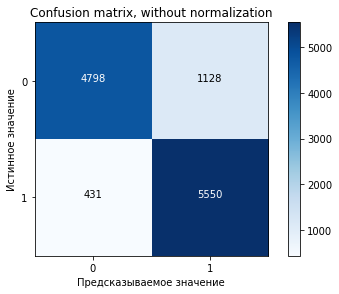

In [18]:
plot_confusion_matrix(
    confusion_matrix(reg_y_test_real, reg_y_test_pred), 
    classes=reg.classes_, 
#     normalize=True,
    title='Confusion matrix, without normalization'
)

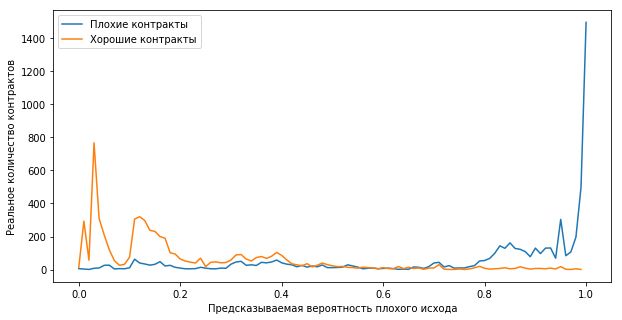

In [19]:
plot_dependence(reg_res)

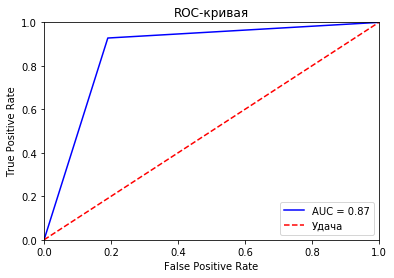

In [20]:
plot_roc_curve(reg_y_test_real, reg_y_test_pred)

### Машина опорных векторов

In [21]:
print('Точность %s на обучающей выборке' % accuracy_score(svc_y_train_real, svc_y_train_pred))
print('Точность %s на тестовой выборке' % accuracy_score(svc_y_test_real, svc_y_test_pred))
print('Потеря перекрестной энтропии %s\n' % log_loss(svc_y_test_real[:len(svc_y_test_pred_proba)], svc_y_test_pred_proba))
print(classification_report(svc_y_test_real, svc_y_test_pred, target_names=('Плохой', 'Хороший')))

Точность 0.873575767756 на обучающей выборке
Точность 0.871924078273 на тестовой выборке
Потеря перекрестной энтропии 0.313688664168

             precision    recall  f1-score   support

     Плохой       0.95      0.78      0.86      5926
    Хороший       0.82      0.96      0.88      5981

avg / total       0.88      0.87      0.87     11907



In [22]:
svc_res = pd.DataFrame({'result': svc_y_test_real}).join(
    pd.DataFrame({'proba_pred': svc_y_test_pred_proba[:,0]}).join(
        pd.DataFrame({'pred': svc_y_test_pred})
    )
)

In [23]:
svc_res.corr()

,result,proba_pred,pred
result,1.000000,-0.789668,0.755704
proba_pred,-0.789668,1.000000,-0.971655
pred,0.755704,-0.971655,1.000000


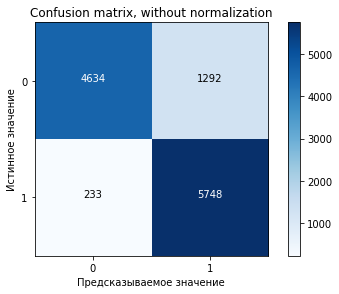

In [24]:
plot_confusion_matrix(
    confusion_matrix(svc_y_test_real, svc_y_test_pred), 
    classes=svc.classes_, 
#     normalize=True,
    title='Confusion matrix, without normalization'
)

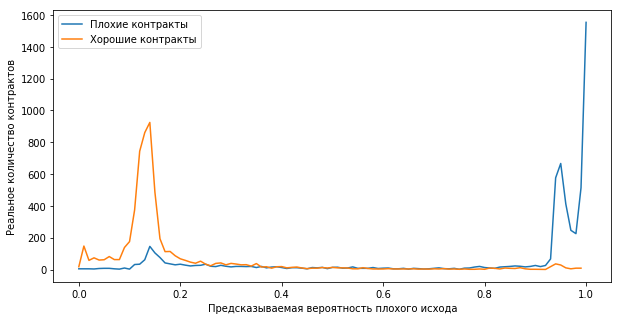

In [25]:
plot_dependence(svc_res)

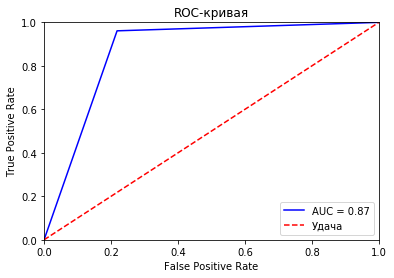

In [26]:
plot_roc_curve(svc_y_test_real, svc_y_test_pred)

### Градиентный бустинг

In [27]:
print('Точность %s на обучающей выборке' % accuracy_score(gb_y_train_real, gb_y_train_pred))
print('Точность %s на тестовой выборке' % accuracy_score(gb_y_test_real, gb_y_test_pred))
print('Потеря перекрестной энтропии %s\n' % log_loss(gb_y_test_real[:len(gb_y_test_pred_proba)], gb_y_test_pred_proba))
print(classification_report(gb_y_test_real, gb_y_test_pred, target_names=('Плохой', 'Хороший')))

Точность 0.919851067999 на обучающей выборке
Точность 0.914756025867 на тестовой выборке
Потеря перекрестной энтропии 0.235962984975

             precision    recall  f1-score   support

     Плохой       0.94      0.89      0.91      5926
    Хороший       0.89      0.94      0.92      5981

avg / total       0.92      0.91      0.91     11907



In [28]:
gb_res = pd.DataFrame({'result': gb_y_test_real}).join(
    pd.DataFrame({'proba_pred': gb_y_test_pred_proba[:,0]}).join(
        pd.DataFrame({'pred': gb_y_test_pred})
    )
)

In [29]:
gb_res.corr()

,result,proba_pred,pred
result,1.000000,-0.859394,0.830660
proba_pred,-0.859394,1.000000,-0.942674
pred,0.830660,-0.942674,1.000000


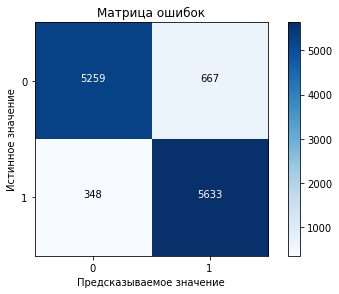

In [30]:
plot_confusion_matrix(
    confusion_matrix(gb_y_test_real, gb_y_test_pred), 
    classes=gb.classes_
)

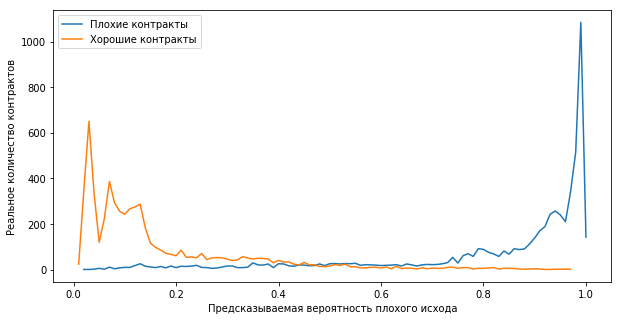

In [31]:
plot_dependence(gb_res)

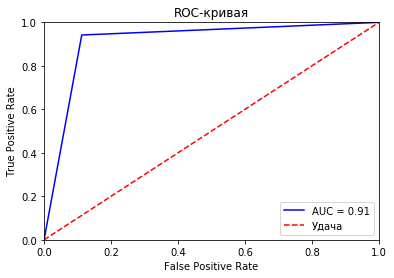

In [32]:
plot_roc_curve(gb_y_test_real, gb_y_test_pred)

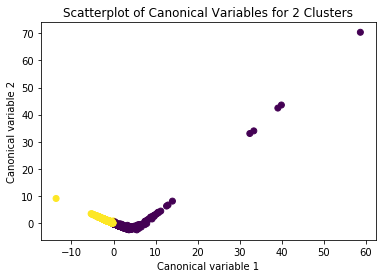

In [33]:
cls_model = KMeans(n_clusters=2).fit(X)
plot_columns = PCA(2).fit_transform(X)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=cls_model.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 2 Clusters')
plt.show()

In [35]:
def export_dataset():
    """Функция для экспорта датасета"""
    
    bad_cntr = pd.read_csv('../data/2-yarobl_bad_contracts.csv')
    good_cntr = pd.read_csv('../data/2-yarobl_good_contracts.csv')
    data = bad_cntr.append(good_cntr)
    data = data.dropna()
    data = shuffle(data)
    data.to_csv(path_or_buf='data.csv')
export_dataset()